# Using Coffea

`ServiceX`:

* Gets columnar data from any format that a transformer has been written for (ATLAS Run 2 xAOD, CMS Run 1 AOD, uproot-able ROOT files, soon some dark matter experiments, etc.)
* Slims, skims, generates calculated quantities

Think _ntuplizer_.

`coffea`:

* Used `awkward` and friends to perform the final analysis
* Plotting
* Distributed running
* Good at running on a large number of datasets at once

`coffea` is arranged around processors that do the physics. Each processor runs once per file, and results are combined for a dataset.


In [1]:
from func_adl_servicex import ServiceXSourceUpROOT
from hist import Hist
import awkward as ak


from coffea import processor


from servicex import ServiceXDataset
from coffea.processor.servicex import DataSource, Analysis
from coffea.processor.servicex import LocalExecutor

In [2]:
ggH125_ZZ4lep = 'root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2020-01-22/4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root'
# ggH125_ZZ4lep = 'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root'

First define a dummy (representative) dataset and apply the operations on it we are interested in:

In [3]:
ds = ServiceXSourceUpROOT('cernopendata://dummy',  "mini", 'uproot-af')
ds.return_qastle = True  # Magic

selection_atlas = (ds
                     .Select(lambda e: Zip({'lep_pt': e['lep_pt'], 'lep_eta': e['lep_eta']}))
                     .Select(lambda leps: leps.Where(lambda l: abs(l.lep_eta) < 1.0))
                     .Select(lambda leps: {'lep_pt': leps.lep_pt, 'lep_eta': leps.lep_eta})
                  )

datasets = [ServiceXDataset([ggH125_ZZ4lep], backend_name='uproot-af')]
c_datasets = DataSource(query=selection_atlas, metadata={'dataset': 'ggH125_ZZ4lep'}, datasets=datasets)

Note:

* no call to `value`: We do not want to try to render this bogus expression.

In [4]:
class atlas_demo_processor(Analysis):
    @staticmethod
    def process(events):
        import awkward as ak

        h = (Hist.new
             .Reg(50, 0, 200, name='lep_pt', label='Lepton $p_T$ [GeV]')
             .StrCat([], name='dataset', label='Dataset', growth=True)
             .Int64()
             )

        dataset = events.metadata['dataset']
        leptons = events.lep

        h.fill(
            dataset=dataset,
            lep_pt = ak.flatten(leptons.pt/1000.0)
        )
                
        return h

Now we create a real dataset and execute it.

This code is boiler plate:

* Declare a dataset and a transformer image
* Create a datasource
* Note the metadata - a useful way to pass information into your processor on a per-dataset basis.

In [5]:
async def run_updates_stream(accumulator_stream):
  count = 0
  async for coffea_info in accumulator_stream:
    count += 1
  return coffea_info

result = await run_updates_stream(
  LocalExecutor().execute(atlas_demo_processor(), c_datasets)
  )

C:\Users\ilija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numba\core\cpu.py:97: UserWarning: Numba extension module 'awkward1._connect._numba' failed to load due to 'ImportError(generic_type: type "kernel_lib" is already registered!)'.
  numba.core.entrypoints.init_all()


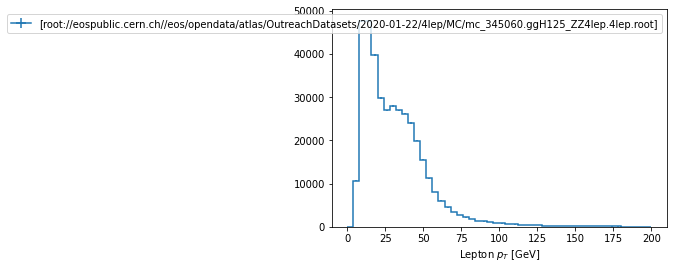

In [6]:
artists = result.plot()

ax = artists[0].stairs.axes  # get the axis
ax.legend(loc="best");